# SCDAA PROJECT

## Setup
Please run the cell below to install packages needed. If they are not installed suggest: !pip install <package>

In [397]:
!pip install nbconvert
import numpy as np
import matplotlib as plt
import pandas as pd
from numpy.polynomial.hermite_e import hermefit, hermeval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import scipy
from scipy.stats import norm

## Question 1 - Empirical Estimation of Conditional Expectation

Calculation of the conditional expectations using probabilists Hermite Polynomials implemented in Numpy. The following functions are written for this calculation and displayed below.

In [353]:
def coeffsForCondiExp(X,Y,hermiteOrder):
    '''
    Exercise 1.1 (i) - Use of hermefit method to estimate the coefficients (beta) used 
    in calculating conditional expectation E[Y|X] from samples X (feature) and Y (output)
    Input: X, Y: np.ndarray (of same dimensions) of samples from two random variables X, Y
    Output: beta : coefficient for each of the samples
    '''
    beta = hermefit(X,Y,hermiteOrder)
  
    return beta

def approxCondExp(X,beta):
    '''
    Evaluate a hermiteE series at point X with coefficients beta
    Input: X: np.ndarray: samples from random variable X
           beta : np.ndarray: coefficients calculated by coeffsForCondiExp function
    Ouput: condExp: the conditional expectation E[Y|X]
    '''
    condExp =  hermeval(X, beta)

    return condExp

def plot_condExp(X,Y, Y_hat, table = False):
    '''
    Plot the conditional expectation
    Return: plot to stdout, and dataframe containing Y, Y_hat, errors, and the final rmse
    '''
    df = pd.DataFrame({'y': Y, 'y_hat':Y_hat, 'error': Y-Y_hat}, columns = ['y', 'y_hat', 'error'])
    error = Y - Y_hat
    rmse = mean_squared_error(Y, Y_hat, squared=False)

    plt.figure(figsize=(12, 6))    
    plt.subplot(121)
    sns.lineplot(x= X, y= Y, color="blue", label= 'True data')
    sns.scatterplot(x= X, y= Y_hat, color = 'red', s = 50, label= 'Fit data').set_title("Fit plot")
    
    plt.subplot(122)
    sns.scatterplot(x = X, y = error).set_title("Residual plot")
    
    plt.subplots_adjust(left=0.0)
    
    plt.legend()
    plt.suptitle("RMSE = " + str(round(rmse, 4)), fontsize=16)
    plt.show()

    if table == True:
        return df, rmse

### Testing of Conditional Expectation approximation

In order to test the functionality of the functions defined above, we apply them to several examples. In these examples we genereally choose an arbitrary function, and attempt to simulate it using Hermite polynomials, and then compare the outcome with a true solution.

Let take two random variables X and Z, where $ Y = f(X) + g(Z) $. For deterministic functions $f$ and $g$, such that $\mathbb E [|f(X)|] + \mathbb E [|g(X)|] < \infty $, we want to calculate $ \mathbb E [Y|X]$, where:

$$ \mathbb E [Y|X] = \mathbb E [|f(X) + g(Z)|X] = f(X) + \mathbb E [g(Z)]$$

Theory stated here for clarity is taken from SCDAA lecture notes at https://www.maths.ed.ac.uk/~dsiska/scdaa_2020-21/ , Example A.40 and Theorem A.39, pp 87.

Therefore, we will first test our algorithms  for correctness, and robustness, with functions of the form described above.

##### Test of functions for an arbitrary function 
In this first example we, take an arbitrary function $f(x) = 2x^3 + \frac{x^2}{2}$, and $ Z \sim Exp(0.5)$, used to create our aribitrary simulated function Y given as $ Y(x) = f(x) + Z $. We assume also that the true function that we are estimating is $ Y^{*}(x) = f(x) + 0.5 $. Using the functions created above, we calculate our hermite coefficients, and conditional expectation $\mathbb{E}[Y|X]$. The plots below show the functions as they were created, and also the results from plotting them in  a 'y=x' format so we can see if they are indeed the same. 

No handles with labels found to put in legend.


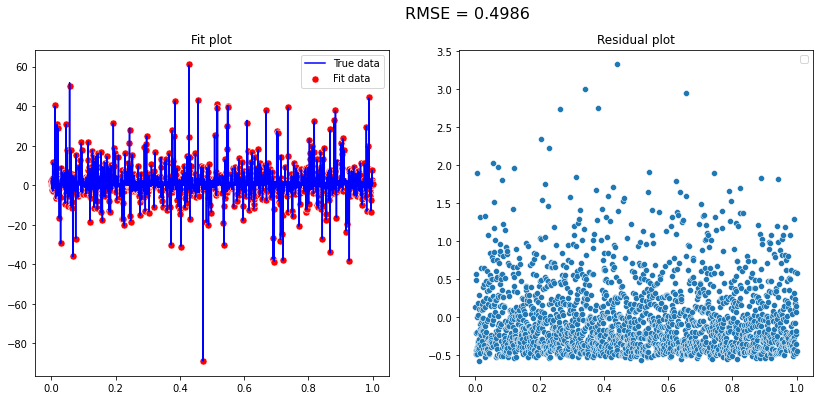

In [354]:
'''
Example 1
'''
# define functions
def f_(x):
    return 2*x ** 3 + 0.5*x**2

lambda_exp = 0.5
X_normal = np.random.normal(loc=0, scale=1, size=2000) 
Z_exp = np.random.exponential(scale=lambda_exp, size=2000) #scale = 1/lambda = mean
Y = f_(X_normal) + Z_exp
trueExp = f_(X_normal) + lambda_exp

#calc E[Y|X]
betas = coeffsForCondiExp(X_normal, Y, hermiteOrder=11)
Y_hat = approxCondExp(X_normal, betas)

# Plot results
grid = np.linspace(0,1,2000)
plot_condExp(grid,Y, Y_hat, table = True) 
error = Y - Y_hat
rmse = mean_squared_error(Y, Y_hat, squared=False) 


As this function is very noisy in nature, the left hand plot does not show the similarity between simulations and true functions especially clearly. Therefore in the plots below, we plot the two traces with an offset applied to the simulated function to distinguish it from the true values, and then plot them against one another (as y=x) so we can very easily see how good a match they are.

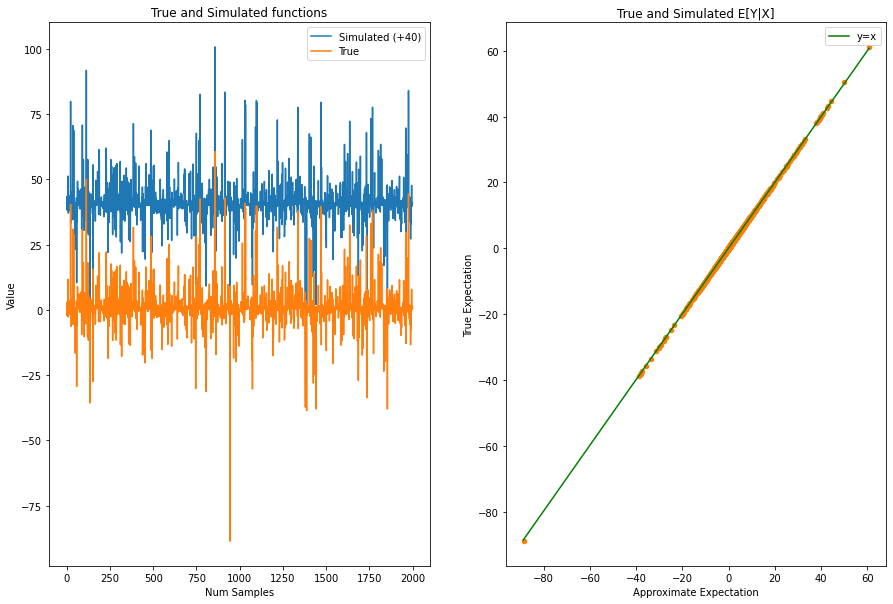

In [355]:
# Plotting using matplotlib
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(Y+ 40) # could use p.5*max(trueExp) as offset? 
ax1.plot(trueExp)
ax1.set_title('True and Simulated functions')
ax1.set_xlabel('Num Samples')
ax1.set_ylabel('Value')
ax1.legend(['Simulated (+40)','True'])

ax2.scatter(trueExp, Y_hat, s=20, color = '#FC7C04')
ax2.plot(np.linspace(min(Y), max(Y)), np.linspace(min(trueExp), max(trueExp)), color = 'g')
ax2.set_title('True and Simulated E[Y|X]')
ax2.set_ylabel('True Expectation')
ax2.set_xlabel('Approximate Expectation')
ax2.legend(['y=x'])


##### Sensitivity of RMSE to Hermite orders used: 
Next, we define a function that calculates and plots the conditional expectation $\mathbb{E}[Y|X]$. In this case, $ Y = 3x^2 + \frac{1}{2}Z$, $Z\sim N(0,1)$, and, $X = 2Z $. We use the function
 below to calculate the RMSE using the functions defined above. Then we do a short study on how well our functions approximate with varying hermite order.

In [356]:
def first_test(hermite_order,test_samples = 1000, plot = True, plot_last = True):
    '''
    Inputs: Hermite order - number of hermite polynomials
    '''
    # Set test samples, create X, Y data
    X = 3*np.random.normal(0,1,test_samples)
    Y = 3*(X**2) + .5*np.random.normal(0,1,test_samples)

    # Fit data to Hermite Coeffs
    coef = coeffsForCondiExp(X,Y,hermite_order)
    # Evaulate conditional expectation
    Y_hat = approxCondExp(X,coef)

    error = Y-Y_hat
    rmse = mean_squared_error(Y, Y_hat, squared=False)

    if plot_last == True:
        plot_condExp(X,Y, Y_hat, table = True) 
    
    if plot == True:
        print(f'rmse == {rmse}')
        plt.plot(error)
        plt.title('errors')
        plt.show()
    
    return rmse 

We call the functions defined above for the hermite order = 12, and show the goodness of fit and the residuals that are calculated for this particular case. We then run this again for other hermite orders and observe the behaviour. In this case, we can see that with a hermite order equal to 2 we get the RMSE to decrease almost to zero, and higher orders do not represent an important improvement in the RMSE, in fact it increses the computational effort. Moreover, the order of hermite equal to 2 is consistent with the function Y we defined above. 

All plots are shown as a result of the cell below. 

No handles with labels found to put in legend.


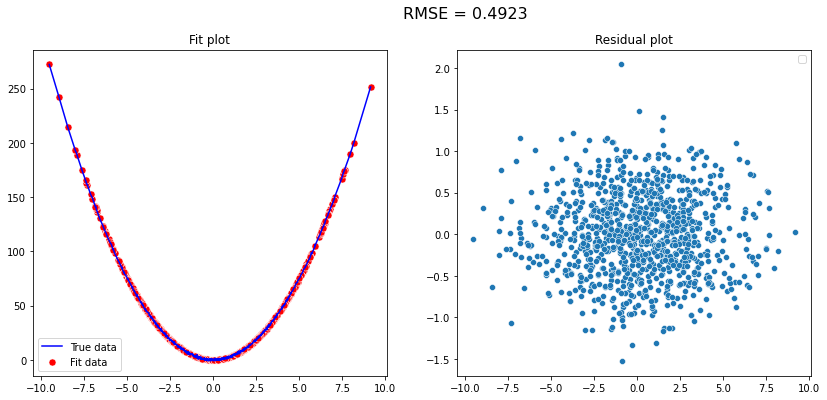

[38.74481934532192, 37.573670699127355, 0.5004864458814572, 0.48483398760958085, 0.5162311454316316, 0.5075933474894432, 0.5178504082682892, 0.4858683351688601, 0.5153808110527202, 0.48602012063752204, 0.5038437871830737, 0.5047006403037164, 0.49230951703537074]


Text(0.5, 1.0, 'RMSE plots with hermite order increasing')

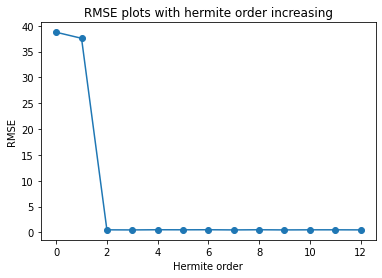

In [357]:
hermite_order = 12
rmse = []
for sample in range(hermite_order +1):
    # Code runs for each hermite order up to max (12), but only shows plots for final order.
    if sample == hermite_order:
        plot_last = True
    else:
        plot_last = False
    rmse.append(first_test(sample, plot = False, plot_last= plot_last))
print(rmse)

plt.scatter(list(range(hermite_order+1)), rmse)
plt.xlabel('Hermite order')
plt.ylabel('RMSE')

sns.lineplot(x = list(range(hermite_order+1)) , y = rmse).set_title('RMSE plots with hermite order increasing') 

Lastly, we use the following example where $X$ is defined as a linear grid, $Z\sim N(0,1)$, and $Y = X + Z $ as before. We also proceed to scan this over hermite orders as a further test. In this case, we see in the plot below,that the best hermite order is equal to one, which is consistent with the definition for Y.

No handles with labels found to put in legend.


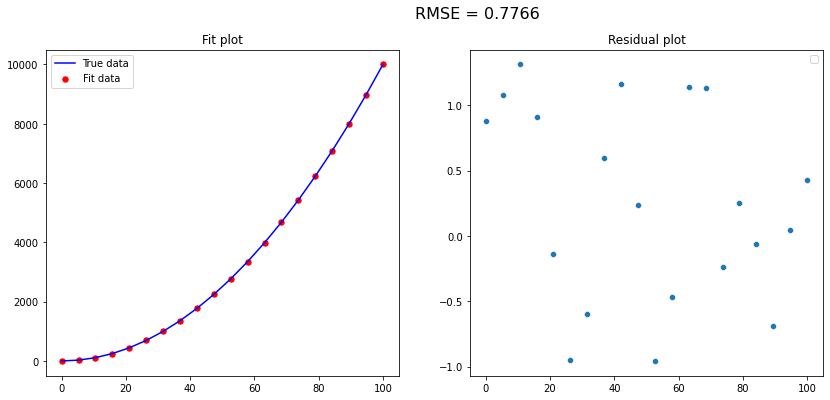

Text(0.5, 1.0, 'RMSE plots with hermite order increasing')

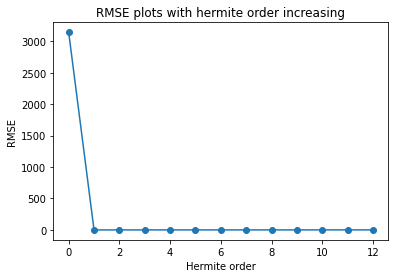

In [358]:
'''Final test for Q1 - X is linear, Z~N(0,1), Y=X+Z
'''
samples = 20
last_value = 100 
grid = np.linspace(0, last_value, samples)
X = np.linspace(0, last_value, samples)**2
Z = np.random.normal(0,1,samples) 
Y = X + Z 

# Fit data to Hermite Coeffs
coef = coeffsForCondiExp(X,Y,12)
# Evaulate conditional expectation
Y_hat = approxCondExp(X,coef)
# Calculate errors
error = Y_hat - X

plot_condExp(grid,X, Y_hat, table = False)

hermite_order = 12
rmse = np.empty(hermite_order+1) # added this for you <3 or it doesnt run!
for i in range(hermite_order + 1 ):
    coef = coeffsForCondiExp(X,Y,i)# Fit data to Hermite Coeffs
    Y_hat = approxCondExp(X,coef)# Evaulate conditional expectation
    rmse[i] = mean_squared_error(X, Y_hat, squared=False)

plt.scatter(list(range(hermite_order+1)), rmse)
plt.title('RMSE plots with hermite order increasing')
plt.xlabel('Hermite order')
plt.ylabel('RMSE')
sns.lineplot(x = list(range(hermite_order+1)) , y = rmse).set_title("RMSE plots with hermite order increasing") 

##### Summary

We initially show that our function is correct by testing it on a noisy function containing multiple distributions, and observe that a good fit is found between the simulated and true data. We obtain RMSE of 0.49 for this example, and this combing with a good fit indicates that the functions are correct. To further test, we scan through our hermite orders for the two separate functions. The optimal hermite order was consistent with the function established. We obtain RMSE values of 0.50 and 0.79 respectively. 


## Question 2 - Solving a BSDE numerically

We define first the simple function to calculate the Black and Scholes price to verify our solution to the BSDE. `BSM_price` and `BSM_delta` are the Black Scholes model calculated price, and the assiciated greek Delta.
The parameters used for the model are:
- `S_0` is the initial price at time `t=0`
- `T` - maturity time
- `K` - strike price of call option
- `r` and `sigma` are the interest rate and volatility respectively

In [359]:
'''Black Scholes model test bed
'''
def d1(S,K,T,r,sigma):
    return (np.log(S/K)+(r+sigma**2/2)*T)/sigma* np.sqrt(T)
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma* np.sqrt(T)

def black_scholes_calc(S_0,K,T,r,sigma):
    BSM_price = S_0 * norm.cdf(d1(S_0,K,T,r,sigma)) - K*np.exp(-r*T) * norm.cdf(d2(S_0,K,T,r,sigma))
    BSM_delta = np.exp(-r*T)* norm.cdf(d1(S_0,K,T,r,sigma))
 
    return BSM_price, BSM_delta

Function to calculate the solution to the associated BSDE:

In [360]:
def BSDE_BSM2(N_mc, N, T, S_0, r, sigma, mu, K,hermite_order = 10, plot=True):

    dt = T/(N-1)
    time_steps = np.linspace(0,T,N, endpoint=True) # time_steps 

    # ===== Generate sample paths for GBm ================ #  
    dW = np.sqrt(dt) * np.random.randn(N_mc,N-1)
    W_paths = np.zeros((N_mc, N))
    W_paths[:, 1:] = np.cumsum(dW, axis=1)
 
    S_values = np.zeros([N_mc,N])
    S_values[:,0] = S_0

    for i in range(1,len(time_steps)):
        #S_values[:,i] = S_values[:,i-1]* np.exp((mu - sigma**2 /2 )* dt + sigma * dW[:,i])
        S_values[:,i] = S_0* np.exp((mu - sigma**2 /2)* time_steps[i] + sigma * W_paths[:,i])
        
    #===== Solves the BSDE ======
    Y = np.zeros([N_mc,N]) # initiate Y(2dim)
    Z = np.zeros([N_mc,N])

    # Terminal value
    Y_N = np.zeros(N_mc) # initiate last step of Y (Y_N) as zero column
    S_T = S_values[:,-1]  # final steps of each S_values in a column
    
    for i in range(N_mc):
        Y_N[i] = np.max([S_T[i] - K, 0]) #call option payoff

    Y[:,-1] = Y_N #terminal value (payoff of the option)

    for i in range(N-2,-1,-1):
        # get coeffs for Z
        coef_Z = coeffsForCondiExp(S_values[:,i],Y[:,i+1] * (W_paths[:,i+1]-W_paths[:,i]),hermite_order)     
        # Calc Z
        Z_hat = approxCondExp(S_values[:,i],coef_Z) * (1/dt)
        Z[:,i] = Z_hat

        g = r * Y[:,i+1] + (1/sigma) * (mu-r) * Z[:,i]

        # get coeffs for Y
        coef_Y =  coeffsForCondiExp(S_values[:,i],Y[:,i+1] - g * dt,hermite_order)
        # Calc Y
        Y_hat = approxCondExp(S_values[:,i],coef_Y)
        Y[:,i] = Y_hat


    if plot == True:
        
        plt.figure(figsize=(12, 6))    
        plt.subplot(121)
        plt.plot(time_steps, S_values[0:50,:].T) #plot stock price simulation
            
        plt.subplot(122)
        plt.plot(time_steps, Y[0:50,:].T)
        
        plt.subplots_adjust(left=0.0)
        plt.show()

    BSM_price, BSM_delta = black_scholes_calc(S_0,K,T,r,sigma)

    return Y[0,0], Y, BSM_price, BSM_delta, Z #, W_paths, dW

Setup Parameters for the BSDE Calculation:

In [361]:
# Setup Parameters
N_mc = 5000# Number of simulations
N = 500 # Number of timesteps in each trajectory
T = 1 # maturity time
S_0,r,sigma,mu, K = 100, 0.02, 0.2, 0.05, 95 


Calculation of the BSDE Solution and comparison to the Black Scholes calculation, along with the error in the calculation:

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


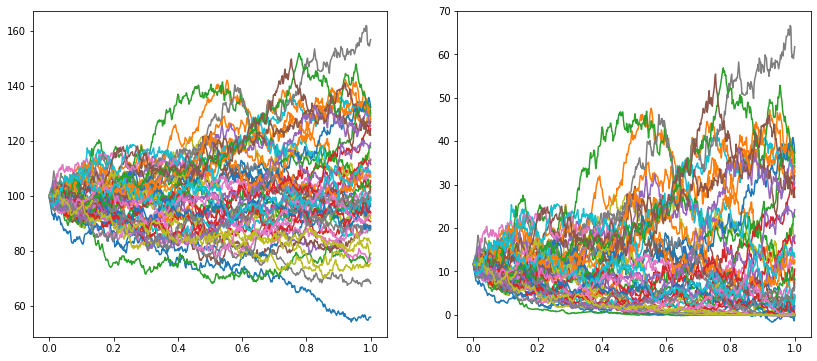

Final value of Y === 11.73169
Price from Black Scholes === 11.61377
Error BSDE vs BSM: 0.11792141449651261


In [362]:
# Calculate prices
sol_Y, path_Y, BSM_price, BSM_delta, Z_full = BSDE_BSM2(N_mc, N, T, S_0, r, sigma, mu, K,hermite_order = 20, plot=True)

print(f'Final value of Y === {round(sol_Y,5)}')
print(f'Price from Black Scholes === {round(BSM_price,5)}')

print(f'Error BSDE vs BSM: {sol_Y - BSM_price}')
# var = Z_full[0,0]/ sigma
# print(f'Compare Z[0,0] to BSM delta:{var} and {BSM_delta*S_0}')
# print(Z_full[0,0], sigma, var, BSM_delta)

# Z_full

The plot on the left side shows the forward paths from an initial $S_0$, calculated from the true solution of the SDE: $dS_t = \mu S_t dt + \sigma S_t dW_t$, given as $S_t = S_0 exp((\mu -\sigma^2/2) t + \sigma W_t)$, where $W_t \sim N(0,t)$. The plot on the right shows that solving the BSDE, using the W paths from the different prices $S_t$ create before, the intial value $Y_0$ for every path converges to the price of a call option with the payoff stated. Thus, the initial value of Y is compared to the Black scholes price which is consistently with order of 1% (the values change as the code here runs so we have refrained from naming specific values). 

### Further Experiments for Q2
We conduct three experiments to verify the convergence of the BSDE solution with respect to the true solution obtained from the BS formula, by varying the following parameters.

1. Testing number of Monte Carlo Samples `N_mc` (`hermite order`, `N` timesteps = constant)
2. Testing N timesteps `N = 2,4,8,16,...,1024` (`N_mc`, `hermite_order` = constant)
3. Testing `hermite_order =1,2,3 ...,10` (`N_mc`, `N` timesteps = constant)

The summary of each experiment is written in the summary of question 2.

##### 1. Testing number of Monte Carlo Samples `N_mc` (`hermite order`, `N` timesteps = constant)

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


[None, None, Text(0.5, 0, 'Monte Carlo samples'), Text(0, 0.5, 'Error')]

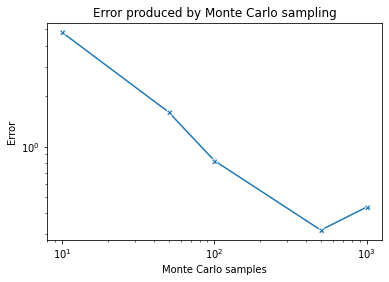

In [363]:
# Warning! This cell takes approx 5 minutes to run!
'''Increasing Monte carlo samples
'''
N_mc_samples = [10,50,100,500,1000] #,5000,10000]
T, N, hermite_order = 1, 2000, 10
S_0,r,sigma,mu, K = 100, 0.02, 0.2, 0.05, 95 
evaluations = 10
errors = np.zeros([evaluations,len(N_mc_samples)])
final_error = []

for i in range(len(N_mc_samples)):
    for j in range(evaluations):
        sol_Y, paths_Y, BSM_price, BSM_delta,Z_full = BSDE_BSM2(N_mc_samples[i], N, T, S_0, r, sigma, mu, K, hermite_order, plot=False)
        #print(np.abs(sol_Y - BSM_price))
        errors[j,i] = np.abs(sol_Y - BSM_price)
    
    final_error.append(np.mean(errors[:,i]))

splot = sns.lineplot(x = N_mc_samples , y = final_error, marker='X')
splot.set_title("Error produced by Monte Carlo sampling")
splot.set(xscale='log', yscale = 'log',xlabel='Monte Carlo samples', ylabel='Error')

##### 2. Testing N timesteps `N = 500, 1000, 2000, 5000, 10000` (`N_mc`, `hermite_order` = constant)

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


[None, None, Text(0.5, 0, 'Number of timesteps'), Text(0, 0.5, 'Error')]

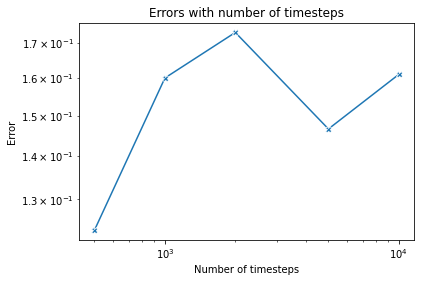

In [ ]:
# Warning! This cell takes approx 5 minutes to run!
'''Increasing number of timesteps N
'''
N_timesteps = [500, 1000, 2000, 5000, 10000] # N_timesteps = [2**power for power in range(2,8)]
N_mc_samples = 5000
T, hermite_order = 1, 10
S_0,r,sigma,mu, K = 100, 0.02, 0.2, 0.05, 95 
evaluations = 20
errors = np.zeros([evaluations,len(N_timesteps)])
final_error_Ntimesteps = []

for i in range(len(N_timesteps)): 
    for j in range(evaluations):
        sol_Y, paths_Y, BSM_price, BSM_delta, Z_full = BSDE_BSM2(N_mc_samples, N_timesteps[i], T, S_0, r, sigma, mu, K, hermite_order, plot=False)
        errors[j,i] = np.abs(sol_Y - BSM_price)
    
    final_error_Ntimesteps.append(np.mean(errors[:,i]))

splot = sns.lineplot(x = N_timesteps , y = final_error_Ntimesteps, marker='X')
splot.set_title("Errors with number of timesteps")
splot.set(xscale='log', yscale = 'log',xlabel='Number of timesteps', ylabel='Error')


##### 3. Testing `hermite_order = 1,2,3 ...,10` (`N_mc`, `N` timesteps = constant)

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


[None, None, Text(0.5, 0, 'Hermite order'), Text(0, 0.5, 'Error')]

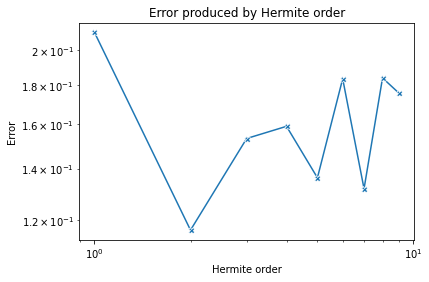

In [ ]:
# Warning! This cell takes approx 5 minutes to run!
'''Increase Hermite Order
'''
hermite_orders = range(1,10)
T,N, N_mc_samples = 1, 2000, 5000
S_0,r,sigma,mu, K = 100, 0.02, 0.2, 0.05, 95 
evaluations = 20
errors = np.zeros([evaluations,len(hermite_orders)])
final_error_hermite = []

for i in range(len(hermite_orders)):
    for j in range(evaluations):
        sol_Y, paths_Y, BSM_price, BSM_delta, Z_full = BSDE_BSM2(N_mc_samples, N, T, S_0, r, sigma, mu, K, hermite_orders[i], plot=False)
        errors[j,i] = np.abs(sol_Y - BSM_price)

    final_error_hermite.append(np.mean(errors[:,i]))

splot = sns.lineplot(x = hermite_orders , y = final_error_hermite, marker='X')
splot.set_title("Error produced by Hermite order")
splot.set(xscale='log', yscale = 'log',xlabel='Hermite order', ylabel='Error')

##### Summary for Q2
Firstly we solve the BSDE set out in the question, and we verify our solution with the standard Black and Scholes model for price of a call option, and we see good agreement between the two with an error of around 1%. Due to this process being fundamentally driven by a random process, there is some variation but we felt that this is a good level of similarity. 

We conducted three more experiments to verify the convergence of the BSDE solution with respect to the true solution obtained from the BS formula, and to verify that our system behaves as we expect. The first experiment varies the number of monte carlo (MC) samples (i.e. sample paths), which is expected to have a significant impact on our price prediction. By increasing MC samples, we are propagating many possible payoffs through our BSDE, and we find that they converge toward to a single initial price at `t=0`. This happens with increasing accuracy as we increase the number of MC samples as is shown but the reduction in RMSE as `N_mc_samples` grows. As the number of `N_mc_samples`$ \rightarrow \infty$ then we will converge with a better accuracy on the true value. Error here are defined as the difference between the Black scholes price and the calculated price, and this drops approximately as $ x^{-0.6}$ (where x>0). 
The second experiment shows how the behaviour changes as we increase the number of timesteps, i.e. setting a big number for N. We maintain maturity time $T=1$, but divide the grid into increasing numbers of divisions. We expect to find that as the number of time steps increases that the error becomes small, but in our experiment we do not seee a clear trend. We observe some quite erratic and almost increasing errors as we increase the timesteps. We cannot attirbute this purely to randomness and ran as many trials as hardware would allow with similar results. 
The third experiment we vary the hermite orders that are used, ranging from 1 to 12. We also expect to find that the errors will decrease as the hermite orders increase, however we also will begin to see what we call 'overfitting' of the solution with high orders. Our results show that as expected, a hermite order of 1 gives a larger error, but then beyond this the behaviour is once again, reasonably erratic. Once again, a hard limit was reached on numbers we could use, choosing as large number of timesteps and MC samples as we could. 

## Question 3 - Deterministic Linear Quadratic control

In this question we implement the method of successive approximation (MSA) for our control problem.

The first part of this algorithm is to solve for our ordinary differential equation system. In the following we produce the analytical solution for $Y_t$ and $X_t$, where $t\in[0,T]$. We assume the following to start with.
$$
\begin{aligned}
C_t, F_t= 0 \\
M_t, H_t = 1 \\
D_t, R(t) = -1 \\
\end{aligned}
$$
We further set $\sigma = 0$, as we are working in the deterministic case. Therefore, the Hamiltoninan will be in the form:
$$
\begin{aligned}
H(t,X_t, Y_t,\alpha_t) = b(t,X_t,Y_z,\alpha_t).y + f(t, X_t, \alpha_t)
\end{aligned}
$$
Given the initial values, the drift and the running reward are in the form:
$$
\begin{aligned}
b(t, X_t, \alpha_t) &= H_tx + M_ta\\
&= X_t + \alpha\\
\end{aligned}
$$

$$
\begin{aligned}
f(t, x, a) &= Cx^2 + D\alpha^2 + 2X_tF_t\alpha \\
&= -\alpha^2
\end{aligned}
$$

So our Hamiltonian H becomes,
$$
\begin{aligned}
H(t,X_t, Y_t,\alpha_t) &= b(t,X_t,Y_z,\alpha_t).y + f(t, X_t, \alpha_t) \\
&= (X_t + \alpha)Y_t - \alpha^2
\end{aligned}
$$

In order to compute the solution of $dY_t$, and further to solve for the control $\alpha$, we need to define the following:
$$
\begin{aligned}
\frac{\partial H}{\partial \alpha} &= Y_t - 2\alpha = 0 \implies \alpha = \frac{Y_t}{2}\\
\frac{\partial H}{\partial X_t} &= Y_t
\end{aligned}
$$

Now, let solve for $dY_t$:
$$
\begin{aligned}
dY_t &= Y_t\:dt \\
\frac{1}{Y_t} dY_t &= dt \implies \ln Y_t = t + constant
\end{aligned}
$$
Using our terminal reward $g(X_t)$ we obtain our boundary condition $Y_T$ and setting R(t) = -1 as above, we have:
$$
\begin{aligned}
g(X_t) &= R(X_t - 5)^2 = -(X_t - 5)^2 \\
Y_T &= \partial _x g \\
&= 2\,R\,(X_T -5) \\
&= 2(5)-2X_T
\end{aligned}
$$
Using this in our expression for $Y_t$,
$$
\begin{aligned}
\ln Y_T = T + constant \implies constant &= \ln Y_T - T \\ constant &= \ln(2(5) -X_T) - T\\ 
\end{aligned}
$$

$$
\begin{aligned}
\ln Y_t = t + \ln(2(5) -2X_T) - T \\
Y_t &= \exp (t + \ln(2(5) -2X_T)) \\
&= \exp(t-T) (2(5) -2X_T)
\end{aligned}
$$
(We have left the 5 in parenthesis rather than simplfying, purely to illustrate that any positive real would work here and we have chosen 5 arbitrarily)

On the other hand, we will use integrating factors to solve dX:
$$
\begin{aligned}
dX_t &= b(t,X_t,Y_z,\alpha_t)\; dt \\
dX_t &= (X_t + \alpha) dt \implies \frac{dX_t}{dt} -X_t = \alpha
\end{aligned}
$$
Multiplying through by our integrating factor $e^{-t}$
$$
\begin{aligned}
e^{-t}\Bigg[\frac{dX_t}{dt} -X_t \Bigg] = \alpha\; e^{-t} \\
\frac{d}{dt}\Big[e^{-t}\alpha \Big] = e^{-t}\Bigg[\frac{dX_t}{dt} -X_t \Bigg] \\
e^{-t} X_t = \int_0^t e^{-s} \alpha(s) ds + constant
\end{aligned}
$$
Using the boundary condition given, $X_0 = x$,

$$
\begin{aligned}
e^{-0} x = \int_0^0 e^{-s} \alpha(s) ds + constant \implies constant = x \\
\implies e^{-t} X_t = \int_0^t e^{-s} \alpha(s) ds + x \\
\end{aligned}
$$

We find the optimal control by computing one step of gradient ascient towards the maximum. This is given below where $\delta>0$ is a small step size determined in our function definitions.
$$
\begin{aligned}
\alpha^{(j)} &= \alpha^{(j-1)} + \delta (\partial _a H)(t, X_t^{(j)}, Y_t^{(j)}, \alpha_t^{j-1})\\
\end{aligned}
$$ 

Lastly we compare the gain $J^\alpha$ and if we have a change less than our convergence parameter $\varepsilon > 0$, i.e. we have reached convergence if $J^{\alpha^{(t-1)}} + \varepsilon > J^{\alpha}$.

In [291]:
'''Setup parameters for  algorithms
'''
N_time = 5000 # Number of timesteps in each trajectory
T = 1 #maturity time
dt = T / (N_time-1)
delta = 0.01 #0.02
epsilon = 0.000001 #1e-5
gain = float('-inf') # big negative number
time_steps = np.linspace(0,T,N_time) # time_steps

x = np.ones(N_time) 
y = np.ones(N_time)
alpha = np.zeros(N_time) #np.ones(N_time)

In [306]:
''' Sub-functions for Linear Quadratic Control
'''
def M(t):
    return 1

def H(t):
    return 1

def C(t): 
    return 0 #for convenience to solve ODE dX_t

def D(t):
    return -1#-1

def R(t):
    return -1

def F(t):
    return 0

def final_reward(x,t):
    #return R(t) * x **2
    return R(t) * (x-5)* (x-5)

def b_(x,t,alpha):
    return H(t) * x + M(t) * alpha

def f(x,t,alpha): 
    return C(t) * x**2 + D(t) * alpha**2 +2*x*F(t)*alpha

def hamiltonian(x,y,t,alpha):
    return b_(x,t,alpha) * y + f(x,t,alpha)

def dg_by_dx(x,t):
    #return 2* R(t) * x
    #return 2 * R(t) *  (x - 5)
    return  R(t) * (2 * x - 10)

def dHam_by_da(y,x,t, alpha):
    return M(t) * y + 2* alpha * D(t) + 2*x*F(t) 

def dHam_by_dx(x, y, t,alpha):
    return y*H(t) + 2*x*C(t) + 2*F(t)*alpha 


The following function implements the linear quadratic control.

In [307]:
def Linear_quadratic_control(T, N, x, y, epsilon, alpha, delta, max_iterations):
    gain = float('-inf')# big negative number
    time_steps = np.linspace(0,T,N) # time_steps
    dt = T/N#(N-1)
    iteration = 1
    J_list = []
    
    for iterations in range(max_iterations):
        
        for i in range(N-1):
            x[i+1] = x[i] + dt * b_(x[i],time_steps[i],alpha[i])
            #print(sum(x))
        #backward
        y[-1] = dg_by_dx(x[-1],time_steps[-1]) #2
        for i in reversed(range(1,N)):
            y[i-1] = y[i] - dt* dHam_by_dx(x[i],y[i],time_steps[i] ,alpha[i]) 
           

        #solve for max alpha - algorithm part(ii)
        for i in range(N):
            alpha[i] = alpha[i] + delta * dHam_by_da(y[i],x[i],time_steps[i],alpha[i] ) 

        #calculate the gain by the integral using euler method 
        current_gain = 0
        for i in range(N):
            current_gain = current_gain + dt * f(x[i],time_steps[i],alpha[i])
        
        current_gain = current_gain + final_reward(x[N-1],time_steps[N-1])
        J_list.append(current_gain)

        # conditions for gain stability
        if current_gain < gain:
            print('Method Failed')
            return 0,0,0,0,0,0 
        elif gain + epsilon > current_gain:
            print("Method converged")
            return J_list,current_gain, iteration, x,y,alpha
            break
        else: 
            gain = current_gain

        iteration = iteration + 1

In [347]:
N_time = 2000 # Number of timesteps in each trajectory
T = 1 # Maturity
dt = T / (N_time-1) #granularity of time grid
delta = 0.01 # gradient ascent rate
epsilon = 0.0001 # convergence parameter
gain = float('-inf')# big negative number
time_steps = np.linspace(0,T,N_time) # time_steps
max_iterations = 300

#initialise 
x = np.ones(N_time) 
y = np.ones(N_time)
alpha = np.zeros(N_time)

J, J_actual, iteration, X, Y,alphas = Linear_quadratic_control(T, N_time, x, y, epsilon, alpha, delta, max_iterations)
print('Final gain of ', round(J_actual,5), 'with', iteration, 'iterations')
Q3_result_for_Q4 = J_actual #Result for question stored for later


Method converged
Final gain of  -1.87244 with 160 iterations


Final gain (J) converges to -1.87244(shown in plot as horizontal magenta line)


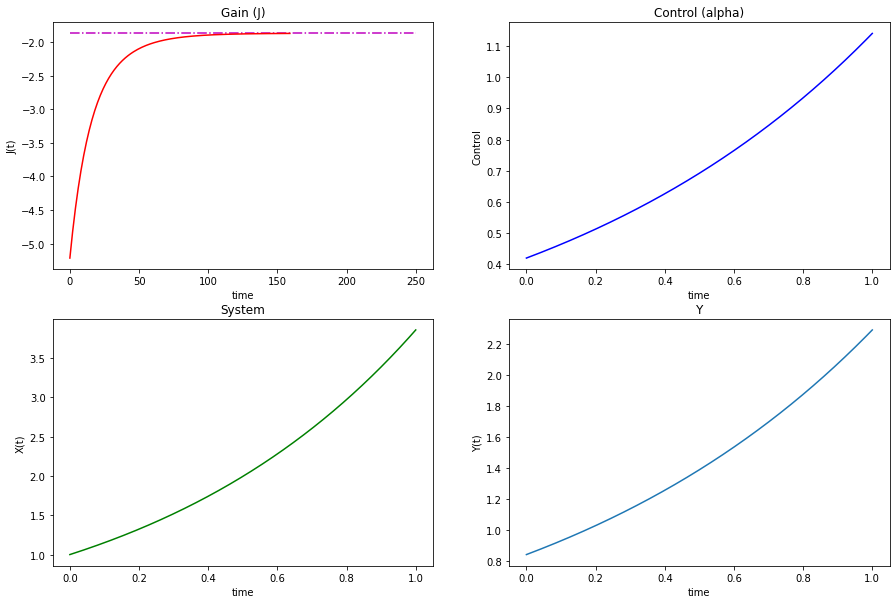

In [348]:
''' Create grid of subplots to show results for Q2 algorithm
'''
x = np.linspace(0,1,N_time) # time grid for all plots

# Subplot, one each for Gain, Control, X(system) and Y
fig, axis = plt.subplots(2,2, figsize=(15,10))
axis[0,0].plot(list(range(len(J))), J, color = 'r')
axis[0,0].hlines(max(J),0,250, linestyles='dashdot', colors='m')
axis[0,0].set_title('Gain (J)')
axis[0,0].set_ylabel('J(t)')
axis[0,0].set_xlabel('time')

axis[0,1].plot(x, alphas, color = 'b')
axis[0,1].set_title('Control (alpha)')
axis[0,1].set_ylabel('Control')
axis[0,1].set_xlabel('time')

axis[1,0].plot(x, X, color = 'g')
axis[1,0].set_title('System')
axis[1,0].set_ylabel('X(t)')
axis[1,0].set_xlabel('time')

axis[1,1].plot(x, Y)
axis[1,1].set_title('Y')
axis[1,1].set_ylabel('Y(t)')
axis[1,1].set_xlabel('time')

print(f'Final gain (J) converges to {(round(max(J),5))}(shown in plot as horizontal magenta line)')

We can see from the plot for the gain, that the function J is converging to the value specified, and we have plotted a horizontal line to highlight this. Note here that we obtain -1.8724 (rounded). 

#### Testing against the analytical solution
To test the solution we have reached above by the Euler method, we compare the analytical solutions $X_t$ and $Y_t$ (given above) to our results. Recall from above that we have:

$$X_t = e^t(\int_0^te^{-s}\alpha_s ds + x)$$
 
$$Y_t = e^{t-1}(2(5)-2X_1)$$

where $T=1$ is our maturity time. The comparisons below show that our $X$ and $Y$ processes are correct to the precision of the convergence parameter. 

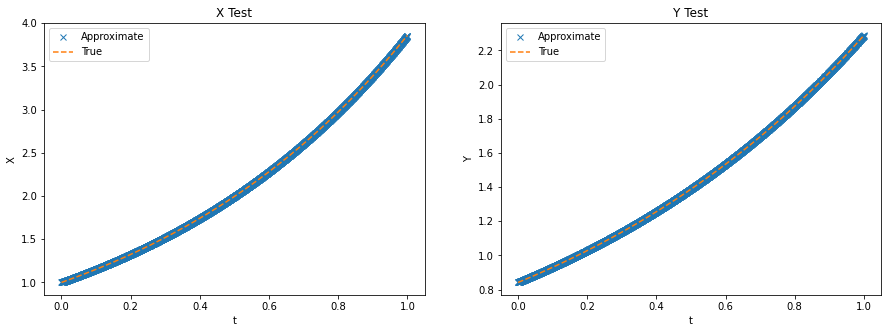

In [349]:
''' Test true value for X and Y
X_true: analytical solution
Y_true: analytical solution

'''
# Initialise X_true
X_true = np.zeros(N_time)
X_true[0] = 1 #initial condition

#Set time params
t = np.linspace(0, 1, N_time)
dt = 1/N_time

integral = 0
#Analytical solution for X using
for i in range(N_time):
    integral = integral + dt * (np.exp(-t[i]) * alphas[i])
    X_true[i] = np.exp(t[i]) * (integral + X_true[0])

#Analytical solution for Y
Y_true = np.zeros(N_time)
for i in range(N_time):
    Y_true[i] = np.exp(t[i] - 1) * (10 - 2 * X[-1])
    
#Plotting
fig, axis = plt.subplots(1, 2, figsize=(15,5))

axis[0].plot(t, X, 'x')
axis[0].plot(t, X_true, "--")
axis[0].set_title('X Test')
axis[0].set_xlabel('t')
axis[0].set_ylabel('X')
axis[0].legend(['Approximate', 'True'])

axis[1].plot(t, Y, 'x')
axis[1].plot(t, Y_true, '--')
axis[1].set_title('Y Test')
axis[1].set_xlabel('t')
axis[1].set_ylabel('Y')
axis[1].legend(['Approximate', 'True'])

In [204]:
# Quick final confirmation of the errors by taking the average of computer minus true solution:
print(f'Average difference between computed and true solutions == {np.mean(Y-Y_true)}')

Average difference between computed and true solutions == 0.0001512032705031936


We see a good agreement here between the analytical solution and the computed solution, indicating that our implementation is correct.

Recall also our analytical solution for the control:  $\alpha_t = Y_t / 2$

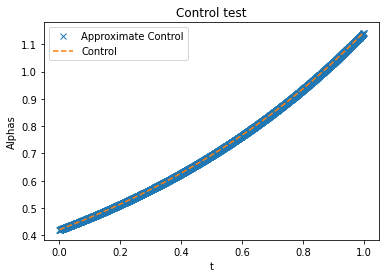

In [350]:
#optimal control is must be Y/2 
plt.plot(t, alphas, "x")
plt.plot(t, (Y_true)/2, "--")
plt.title('Control test')
plt.xlabel('t')
plt.ylabel('Alphas')
plt.legend(['Approximate Control', 'Control'])

The analytical solution for the control also shows a good agreement, implying that the implementation is correct.

In [305]:
''' Calculates prices using the model above for fixed parameters
'''
N_time = 2000 #20 # Number of timesteps in each trajectory
T = 1 #maturity time
delta = 0.2#0.02
epsilon = 0.0001#1e-5
gain = float('-inf')# big negative number
time_steps = np.linspace(0,T,N_time) # time_steps
max_iterations = 300

#initialise time grid
x = np.ones(N_time) 
y = np.ones(N_time)
alpha = np.zeros(N_time)
J, J_actual, iteration, X, Y, alphas = Linear_quadratic_control(T, N_time, x, y, epsilon, alpha, delta, max_iterations)


Method converged


We obtain a converging model here for our intial and somewhat arbitrary parameters. In order to test the how sensible these values are, the following two exercises show the importance of a small $\delta$ used to update the control and, the number of time steps used for corvenge of the different values in the model, e.g. to estimate the solutions of the ODE's.

##### Test for convergence with small value of $\delta$.

Method converged
at delta == 0.01
Method converged
at delta == 0.1
Method converged
at delta == 0.15
Method converged
at delta == 0.2
Method converged
at delta == 0.25
Method Failed
at delta == 0.3


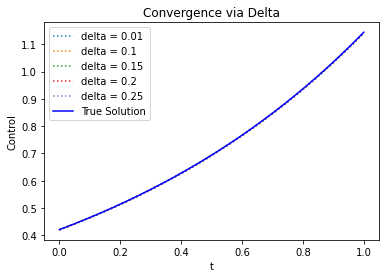

In [364]:
'''Varying Delta, otherwise fundamentally as previous code cell
'''
N_time = 2000 #20 # Number of timesteps in each trajectory
T = 1 #maturity time

deltas=[0.01,0.1,0.15,0.2,0.25,0.3]
epsilon = 0.0001 
gain = float('-inf')# big negative number
time_steps = np.linspace(0,T,N_time) # time_steps
max_iterations = 300

for i in range(len(deltas)):
    x = np.ones(N_time) 
    y = np.ones(N_time)
    alpha = np.zeros(N_time) #np.ones(N_time)

    J, J_actual, iteration, X, Y, alphas = Linear_quadratic_control(T, N_time, x, y, epsilon, alpha, deltas[i], max_iterations)
    if np.mean(Y) !=0:
        plt.plot(time_steps, alphas, linestyle = ':')
        legend.append(f'delta = {deltas[i]}')
    print(f'at delta == {deltas[i]}')

plt.plot(time_steps, Y_true/2, color = 'b')
legend.append('True Solution')
plt.title('Convergence via Delta')
plt.xlabel('t')
plt.ylabel('Control')

plt.legend(legend)

With this exercise we can see that in order to converge the model, small deltas are needed. In fact, as we can see in the graph for $\delta$ greater than 0.3 the the model fails to converge. However, it is interesting to see that for $\delta$ less than 0.3, the model will converge with the same accuracy.

##### Test for convergence with number of timesteps, N.

Method converged
at N == 100
Method converged
at N == 256
Method converged
at N == 512
Method converged
at N == 1028
Method converged
at N == 2048
Method converged
at N == 4096


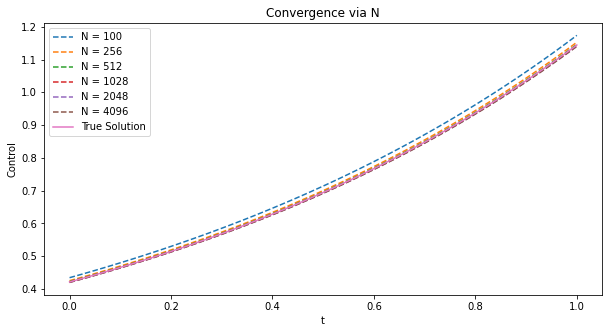

In [374]:
# test convergence for N
N_time = [100, 256, 512, 1028, 2048, 4096]
legend = []
gain = float('-inf')

fig = plt.figure(figsize=(10,5))
for i in range(len(N_time)):

    x = np.ones(N_time[i]) 
    y = np.ones(N_time[i])
    alpha = np.zeros(N_time[i]) #np.ones(N_time)
    time_steps = np.linspace(0,T,N_time[i])

    J, J_actual, iteration, X, Y,alphas = Linear_quadratic_control(T, N_time[i], x, y, epsilon, alpha, delta, max_iterations)
    if np.mean(Y) != 0: 
        plt.plot(time_steps, alphas, linestyle = '--')
        legend.append(f'N = {N_time[i]}')
    print(f'at N == {N_time[i]}')

legend.append('True Solution')
plt.title('Convergence via N')
plt.plot(np.linspace(0,T,2000), Y_true/2)
plt.xlabel('t')
plt.ylabel('Control')
plt.legend(legend)

In this case, we can see the importance of large number of time steps to achieve the true solution. However, it is important to recall the computational effort it implies, so we only go here as far as 5000, where we see very good convergence to the true solution. Moreover, we can see that with around 2000 time steps we still achieve a good accuracy.

##### Summary
We have implemented a model that behaves as we would expect it to - we exercised as many timesteps as we could manage as before. The $\delta$ parameter exhibits almost binary behaviour, converging well at values below 0.3, and performing poorly otherwise. The number of timesteps shows predictably that as our grid becomes finer grained that we step closer to the true solution - but anything beyond 2000 steps for our purposes here shows very good agreement so we adopt this value for other experiments in the remainder of this report unless otherwises stated.

## Question 4 - MSA for stochastic control

In this case, set $\sigma \neq 0$, as we are now working in the stochastic case. Therefore, the Hamiltonian will now return to the form:
$$
\begin{aligned}
H(t,X_t, Y_t,\alpha_t) &= b(t,X_t,Y_z,\alpha_t).y + f(t, X_t, \alpha_t) + \mathbb{tr}(\sigma(t, X_t,\alpha_t)^{T^{*}}z)
\end{aligned}
$$


In order to test the MSA stochastic control, we note that the only difference between the deterministic control modeled in Q3 is the presence of the term in $\sigma$. Therefore, we use the stochastic algorithm with a sufficiently low $\sigma=0.01$, and compare the results with that of deterministic control in Q3. 

In [375]:
'''Setup Functions for Stochastic_Linear_quadratic_control
'''
def M(t):
    return 1

def H(t):
    return 1

def C(t): 
    return 0 #for convenience to solve ODE dX_t

def D(t):
    return -1

def R(t):
    return -1

def F(t):
    return 0

def final_reward(x,t):
    return R(t) * (x-5)* (x-5)

def b_(x,t,alpha):
    return H(t) * x + M(t) * alpha

def f(x,t,alpha): 
    return C(t) * x**2 + D(t) * alpha**2 +2*x*F(t)*alpha

def hamiltonian(x,y,t,alpha):
    return b_(x,t,alpha) * y + f(x,t,alpha)

def dg_by_dx(x,t):
    return  R(t) * (2 * x - 10)

def dHam_by_da(y,x,t, alpha):
    return M(t) * y + 2* alpha * D(t) + 2*x*F(t) 

def dHam_by_dx(x, y, t,alpha):
    return y*H(t) + 2*x*C(t) + 2*F(t)*alpha 

def sigma(x,t,alpha):
    return 0.01 

The following cell implements our stochastic control algorithm.

In [376]:
def Stochastic_Linear_quadratic_control(T, N, x, y, epsilon, alpha, delta, max_iterations,N_mc):
    gain = float('-inf')# big negative number
    time_steps = np.linspace(0,T,N) 
    dt = T/(N-1)
    iteration = 1
    J_list = []
    dW = np.sqrt(dt) * np.random.randn(N_mc,N-1)
    W_paths = np.zeros((N_mc, N))
    W_paths[:, 1:] = np.cumsum(dW, axis=1)
 
    for iterations in range(max_iterations):   
        x = np.ones((N_mc, N))
        y = np.ones((N_mc, N))
        z = np.ones([N_mc,N])
        #Solve Forward SDE
        for i in range(N-1):
            x[:,i+1] = x[:,i] + dt * b_(x[:,i],time_steps[i],alpha[:,i]) + sigma(x[:,i],time_steps[i], alpha[:,i]) * dW[:,i]

        #Solve BSDE
        y[:,-1] = dg_by_dx(x[:,-1],time_steps[-1]) #2

        for i in range(N-2,-1,-1):
            # get coeffs for Z conditioning on W[t] 
            coef_Z = coeffsForCondiExp(W_paths[:,i],y[:,i+1] * (W_paths[:,i+1]-W_paths[:,i]),hermite_order)     
            # Calc Z
            Z_hat = approxCondExp(W_paths[:,i],coef_Z) * (1/dt)
            z[:,i] = Z_hat
        
            g = dHam_by_dx(x[:,i], y[:,i+1], time_steps[i],alpha[:,i])

            # get coeffs for Y
            coef_Y =  coeffsForCondiExp(W_paths[:,i],y[:,i+1] - g * dt,hermite_order)
            
            # Calc Y
            Y_hat = approxCondExp(W_paths[:,i],coef_Y)
            y[:,i] = Y_hat

        #solve for max alpha using gradient ascent
        for i in range(N):
            alpha[:,i] = alpha[:,i] + delta * dHam_by_da(y[:,i],x[:,i],time_steps[i],alpha[:,i] ) 

        #calculate the gain by the integral using euler method 
        current_gain = 0
        for i in range(N):
            current_gain = current_gain + dt * f(x[:,i],time_steps[i],alpha[:,i])

        current_gain = np.mean(current_gain + final_reward(x[:,N-1],time_steps[i]))
        J_list.append(current_gain)

        # conditions for gain stability
        if current_gain < gain:
            print('Method Failed')
            return 0,0,0,0,0,0 
            
        elif gain + epsilon > current_gain:
            print("Method converged")
            return J_list,current_gain, iteration, x,y,alpha,W_paths
            
            break
        else: #go to next iteration
            gain = current_gain

        iteration = iteration + 1


The following parameters were used initialy to gain model convergence.

In [377]:
'''!!! Warning - CELL TAKES EXTREMELY LONG TIME!
'''
N_time = 2000 #20 # Number of timesteps in each trajectory
T = 1 #maturity time
N_mc = 500
hermite_order = 20


x = np.ones((N_mc, N_time))
y = np.ones((N_mc, N_time))
z = np.ones([N_mc,N_time])
alpha = np.zeros((N_mc, N_time))
delta = 0.01 
epsilon = 0.0001 
gain = float('-inf')
max_iterations = 300

J, J_actual, iteration, X, Y,alphas,W = Stochastic_Linear_quadratic_control(T, N_time, x, y, epsilon, alpha, delta, max_iterations, N_mc)

#Stochastic_Linear_quadratic_control(T, N, x, y, epsilon, alpha, delta, max_iterations)

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)
Method converged


In [378]:
print('Final gain of',J_actual,'with', iteration, 'iterations')

Final gain of -1.8697662906064876 with 160 iterations


In [379]:
print('Final gain of',Q3_result_for_Q4, 'from question 3')

Final gain of -1.8724430295334056 from question 3


We refer here to the result saved from the deterministic control problem in Q3. The result we obtain for the stochastic control is close to the result from Q3 given above, giving confidence that this method is performing as expected. We expect this to be the case as we set $\sigma=0.01$, which means the stochastic component is small enough to largely recover the predictions of deterministic control.

Final gain (J) converges to -1.86977(shown in plot as horizontal magenta line)


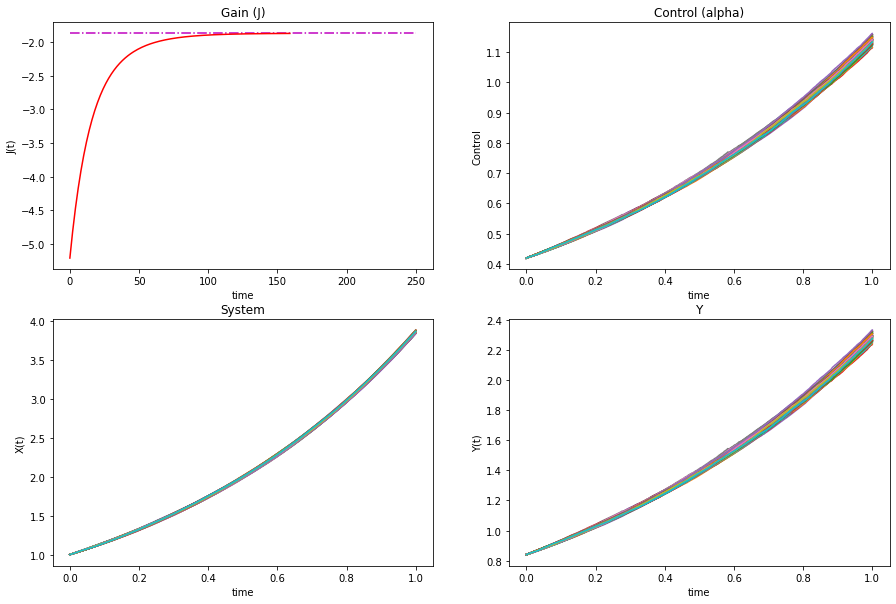

In [380]:
'''Plotting results from Stochastic control for Gain (J), X, Y and controls (alpha)
'''
x = np.linspace(0,1,N_time) # time grid for plots
fig, axis = plt.subplots(2,2, figsize=(15,10))

for i in range(100):
    axis[1,0].plot(x, X[i])
    axis[1,1].plot(x, Y[i])
    axis[0,1].plot(x, alphas[i])

axis[0,0].plot(list(range(len(J))), J, color = 'r')
axis[0,0].hlines(max(J),0,250, linestyles='dashdot', colors='m')
axis[0,0].set_title('Gain (J)')
axis[0,0].set_ylabel('J(t)')
axis[0,0].set_xlabel('time')

axis[0,1].set_title('Control (alpha)')
axis[0,1].set_ylabel('Control')
axis[0,1].set_xlabel('time')

axis[1,0].set_title('System')
axis[1,0].set_ylabel('X(t)')
axis[1,0].set_xlabel('time')

axis[1,1].set_title('Y')
axis[1,1].set_ylabel('Y(t)')
axis[1,1].set_xlabel('time')

print(f'Final gain (J) converges to {(round(max(J),5))}(shown in plot as horizontal magenta line)')


Once again, we look at the same plots as in deteministic case, and we plot again a horizontal line in the gain function to emphasise the convergence to the final gain value stated above.

#### Analytical Solution
Similar to question Q3, we compare the analytical solution of $dX_t$ with the one obtained by the model. Furthermore, we obtain the solution for the control, which is later shown to be a good fit to the predicted results.


$$
\begin{aligned}
dX_t &= [X_t + \alpha_t] dt + \sigma dW_t\\ 
\end{aligned}
$$

$$
\begin{aligned}
X_t - X_0 &= \int_0^t X_s ds + \int_0^t  \alpha_s ds + \sigma W_t \\
X_t &= x + \int_0^t X_s ds + \int_0^t  \alpha_s ds + \sigma W_t
\end{aligned}
$$



$$
\begin{aligned}
H &= Y_t[X_t + \alpha_t] + \sigma Z - \frac{\alpha_t ^2}{2} \\
&\implies \alpha_t = Y_t/2
\end{aligned}
$$

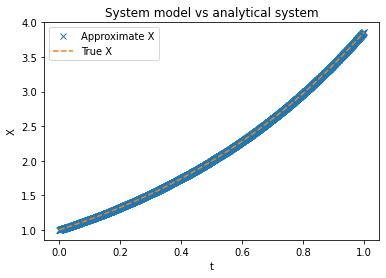

In [407]:
''' Testing for solution of dX_t
'''
X_try = X[0,:]
W_try = W[0,:]
alpha_try = alphas[0,:]
dt = 1/ len(X_try)

X_integral = 0
W_integral = 0
alpha_integral = 0
x_0 = 1
X_true = np.ones(len(X_try))

for i in range(N_time):
    X_integral = X_integral + dt * X_try[i]
    W_integral = W_integral + dt * W_try[i]
    alpha_integral = alpha_integral + dt * alpha_try[i]
    X_true[i] = X_true[0] + X_integral + alpha_integral + sigma(x,t,alpha) * W_integral

t = np.linspace(0, 1, N_time)
plt.plot(t, X_try, "x")
plt.plot(t, X_true, "--")
plt.title('System model vs analytical system')
plt.xlabel('t')
plt.ylabel('X')
plt.legend(['Approximate X', 'True X'])

The trace in the plot marked as true is our analytical solution and shows a good fit to the model (Approximate X).

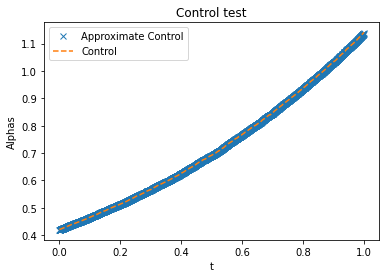

In [382]:
''' Test for for optimal control to be Y/2  
'''
t = np.linspace(0, 1, N_time)
dt = 1/N_time

plt.plot(t, alphas[0,:], "x")
plt.plot(t, Y[0,:]/2, "--")
plt.title('Control test')
plt.xlabel('t')
plt.ylabel('Alphas')
plt.legend(['Approximate Control', 'Control'])

For this model, we did not test for different values of $\delta$ or number of time steps, as testing for one single value in either parameter, takes the model a prohibitively long time to run. However, as in question 3 we expect to see the same behaviour, where for values of $\delta$ that are not small enough the model will fail to converge, given that this is directly associated to the control. In the same way, it is not expected to function well for small numbers of time divisions (e.g. N = 10), as this might have a conflict for achieving a good accuracy.

A difference from previous question is that for this model, we are required to introduce a given number of Monte Carlo samples used to evaluate the conditional expectations for solving $dY_t$. In this way, as tested in question 2, we expect to see that the higher number of samples improves the agreement with the true solution for the BSDE.


#### PDF CREATOR

In [418]:
# !pip install nbconvert
!jupyter nbconvert --to html notebook.ipynb

[NbConvertApp] Converting notebook notebook.ipynb to html
[NbConvertApp] Writing 1822738 bytes to notebook.html


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f035995c-05fa-4d78-a3eb-ad35f9416ab7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>